In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium
from folium import plugins
from folium import FeatureGroup
from config import vworld_key
import json
import math
import re
from datetime import datetime
import os
import glob
import subprocess
from bs4 import BeautifulSoup as bs
from shapely.geometry import Point, Polygon, LineString
import geopandas as gpd
from shapely import wkt
import rasterio
import base64
from matplotlib import pyplot
from rasterio.plot import show
import matplotlib.pyplot as plt

# 모든 열이 생략되지 않도록 설정
pd.set_option('display.max_columns', None)

## tif 파헤치기

In [ ]:
# import os
# import glob
# import subprocess

# # 상위 디렉토리 경로 설정
# base_directory = "dataset/2.안산시_Landsat8"  # 디렉토리 경로 설정

# # 상위 디렉토리 내의 모든 하위 디렉토리 가져오기
# subdirectories = [os.path.join(base_directory, d) for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]

# # 각 서브 디렉토리를 반복하면서 XML 파일 읽기
# for directory in subdirectories:
#     # 입력 폴더에서 모든 TIF 파일 찾기
#     tif_files = glob.glob(os.path.join(directory + '/', "*.tif"))

#     for input_tif in tif_files:
#         # 파일 이름만 추출하여 출력 폴더와 결합
#         input_filename = os.path.basename(input_tif)

#         if not input_filename.endswith("_geotiff.tif"):
#             output_geotiff = os.path.join(directory + '/', input_filename.replace(".tif", "_geotiff.tif"))

#             # gdal_translate 명령어 실행
#             cmd = ["gdal_translate", "-of", "GTiff", input_tif, output_geotiff]

#             try:
#                 subprocess.run(cmd, check=True)
#                 print(f"{input_tif}을 GeoTIFF로 성공적으로 변환했습니다.")
#             except subprocess.CalledProcessError as e:
#                 print(f"{input_tif} 변환 중 오류 발생:", e)

## xml 정보 위성사진에 매핑하기

In [34]:
tif_df = {
    'file_name':[],
    'file_path':[],
    'time':[],
    'imagegeogcenter':[],
    'imagegeogtl':[],
    'imagegeogtc':[],
    'imagegeogtr':[],
    'imagegeogbl':[],
    'imagegeogbc':[],
    'imagegeogbr':[],
}

# 상위 디렉토리 경로 설정
base_directory = "dataset/20.국토지리정보원_위성영상(RGB_NIR)"  # 디렉토리 경로 설정

# 상위 디렉토리 내의 모든 하위 디렉토리 가져오기
subdirectories = [os.path.join(base_directory, d) for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]

# 각 서브 디렉토리를 반복하면서 XML 파일 읽기
for directory in subdirectories:
    # 디렉토리 내의 XML 파일 목록 가져오기
    xml_files = [f for f in os.listdir(directory) if f.endswith("Aux.xml")]

    # 각 XML 파일을 읽어서 처리
    for xml_file in xml_files:
        xml_file_path = os.path.join(directory, xml_file)
                
        with open(xml_file_path, 'r', encoding='utf-8') as f:
            xml_doc = f.read()
        soup = bs(xml_doc, 'lxml')
        # TIFF이미지 형식 1번부터 4번까지 순회(BGRN 순)
        for img_no in range(4,5):

            # soup로 이미지 번호에 해당하는 객체 탐색
            img_lxml = soup.find("MS%s"%img_no) if soup.find("MS%s"%img_no) else soup.find("ms%s"%img_no)
            

            # 이미지 파일이름 추출 및 저장
            tif_df['file_name'].append(img_lxml.find('imagefilename').text)

            # 이미지 파일경로 저장

            tif_df['file_path'].append(directory + '/' + img_lxml.find('imagefilename').text.replace(".tif", "_geotiff.tif"))

            # UTC to yy-mm-dd 변환 및 저장
            text = img_lxml.find('utc').text.split('.')[0]
            datetime_obj = datetime.strptime(text, "%Y%m%d%H%M%S")
            tif_df['time'].append(datetime_obj.strftime("%y-%m-%d"))

            # 이미지 위치정보 저장
            img_point = ['imagegeogcenter', 'imagegeogtl', 'imagegeogtc', 'imagegeogtr', 'imagegeogbl', 'imagegeogbc', 'imagegeogbr'] # 딕셔너리 3~9 column
            lat_lst = img_lxml.find_all('latitude')
            lon_lst = img_lxml.find_all('longitude')
            for point, lat, lon in zip(img_point, lat_lst, lon_lst):
                tif_df[point].append(Point(lon, lat))

xml_metadata_df = pd.DataFrame(tif_df)
xml_metadata_df

,file_name,file_path,time,imagegeogcenter,imagegeogtl,imagegeogtc,imagegeogtr,imagegeogbl,imagegeogbc,imagegeogbr
0,C1_20230624015314_12527_00071291_L2G_N.tif,dataset/20.국토지리정보원_위성영상(RGB_NIR)\C1_2023062401...,23-06-24,POINT (126.709245 37.267593),POINT (126.615293 37.334427),POINT (126.708538 37.335088),POINT (126.801798 37.335675),POINT (126.616871 37.199436),POINT (126.70995 37.200093),POINT (126.803044 37.200678)
1,C1_20230624015314_12527_00093015_L2G_N.tif,dataset/20.국토지리정보원_위성영상(RGB_NIR)\C1_2023062401...,23-06-24,POINT (126.678512 37.370226),POINT (126.584346 37.437072),POINT (126.677775 37.437759),POINT (126.771212 37.438372),POINT (126.585986 37.302003),POINT (126.679248 37.302687),POINT (126.772517 37.303297)
2,C1_20230719015507_12907_00322813_L2G_N.tif,dataset/20.국토지리정보원_위성영상(RGB_NIR)\C1_2023071901...,23-07-19,POINT (126.869954 37.264529),POINT (126.782672 37.330089),POINT (126.869403 37.330583),POINT (126.956147 37.331014),POINT (126.783924 37.197977),POINT (126.870504 37.198468),POINT (126.957097 37.198897)
3,C1_20230808015601_13211_00650427_L2G_N.tif,dataset/20.국토지리정보원_위성영상(RGB_NIR)\C1_2023080801...,23-08-08,POINT (126.92474 37.42322),POINT (126.839744 37.488296),POINT (126.924238 37.488738),POINT (127.008745 37.489119),POINT (126.840894 37.357257),POINT (126.925241 37.357697),POINT (127.0096 37.358077)
4,C1_20230907015813_13667_00052295_L2G_N.tif,dataset/20.국토지리정보원_위성영상(RGB_NIR)\C1_2023090701...,23-09-07,POINT (126.939949 37.356858),POINT (126.856797 37.421518),POINT (126.939465 37.421939),POINT (127.022145 37.422302),POINT (126.857907 37.291348),POINT (126.940432 37.291767),POINT (127.02297 37.292128)
5,C1_20230908013931_13682_00057979_L2G_N.tif,dataset/20.국토지리정보원_위성영상(RGB_NIR)\C1_2023090801...,23-09-08,POINT (126.786612 37.349092),POINT (126.640978 37.427096),POINT (126.785864 37.42806),POINT (126.930761 37.428847),POINT (126.642776 37.269154),POINT (126.787358 37.270113),POINT (126.931952 37.270895)


In [ ]:
import folium
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from folium import plugins

# Folium 맵 생성
m = folium.Map(location=[37.37105949652944, 126.88130200939035], zoom_start=11)  # 지도의 중심 좌표와 줌 레벨 설정

for _, row in xml_metadata_df.iterrows() :
    # GeoTIFF 파일 경로 설정
    geotiff_file_path = row['file_path']  # GeoTIFF 파일의 경로
    # GeoTIFF 파일 열기
    src = rasterio.open(geotiff_file_path)
    array = src.read(1)

    # Shapely Point 객체로 top-left 좌표를 파싱
    tl_point = wkt.loads(str(row['imagegeogtl']))

    # Shapely Point 객체로 bottom right 좌표를 파싱
    br_point = wkt.loads(str(row['imagegeogbr']))

    # 일반 PNG 이미지를 Folium에 추가
    folium.raster_layers.ImageOverlay(
        image=array,
        bounds=[[tl_point.y, tl_point.x], [br_point.y, br_point.x]],
        opacity=0.6,
        interactive=True,
    ).add_to(m)

# Folium 지도를 출력
m

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# TIF 파일 경로 설정
thermal_band_path = 'dataset/2.안산시_Landsat8/LC08_L1TP_116034_20210618_20210628_02_T1/LC08_L1TP_116034_20210618_20210628_02_T1_B1.TIF'  # 열온도를 나타내는 밴드 (10번 또는 11번 밴드)

# SAA, SZA, VAA, VZA TIF 파일 경로 설정
sza_band_path = 'dataset/2.안산시_Landsat8/LC08_L1TP_116034_20210618_20210628_02_T1/LC08_L1TP_116034_20210618_20210628_02_T1_SZA.TIF'
vza_band_path = 'dataset/2.안산시_Landsat8/LC08_L1TP_116034_20210618_20210628_02_T1/LC08_L1TP_116034_20210618_20210628_02_T1_VZA.TIF'

# Rasterio를 사용하여 TIF 파일 열기
with rasterio.open(thermal_band_path) as thermal_src, \
     rasterio.open(sza_band_path) as sza_src, \
     rasterio.open(vza_band_path) as vza_src:

    # 열온도 밴드 읽기
    thermal_band = thermal_src.read(1)

    # SZA 밴드 읽기
    sza_band = sza_src.read(1)

    # VZA 밴드 읽기
    vza_band = vza_src.read(1)

    # 열온도 분포 계산 및 시각화
    # 열온도를 다른 정보와 결합하여 원하는 분포 계산 및 시각화 작업을 수행하세요.
    # 예를 들어, 열온도와 SZA를 결합하여 시각화할 수 있습니다.
    combined_data = thermal_band  * vza_band # 예시: SZA가 0보다 큰 경우에만 열온도 사용
    plt.figure(figsize=(8, 8))
    plt.imshow(combined_data, cmap='jet')  # 원하는 컬러맵 사용
    plt.colorbar(label='Temperature (K)')  # 컬러바 추가 (선택 사항)
    plt.title('Temperature Distribution')  # 그래프 제목 설정 (선택 사항)
    plt.axis('off')  # 축 숨기기 (선택 사항)
    plt.show()

In [25]:
vza_band.shape

(556, 796)

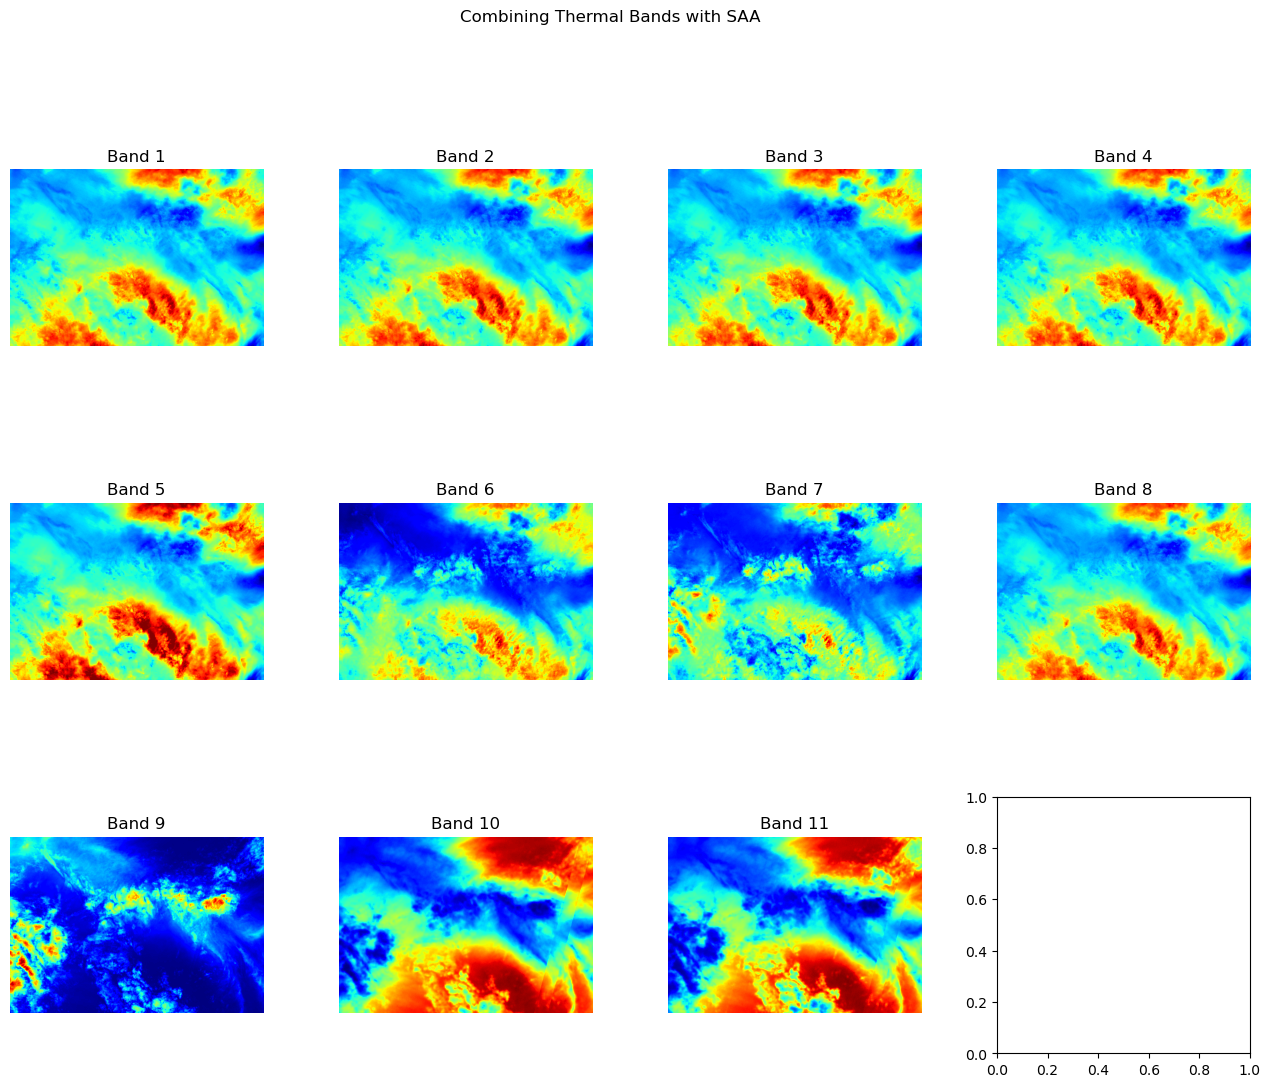

In [37]:
import os
import glob
import subprocess

# 상위 디렉토리 경로 설정
base_directory = "dataset/2.안산시_Landsat8"  # 디렉토리 경로 설정

# 상위 디렉토리 내의 모든 하위 디렉토리 가져오기
subdirectories = [os.path.join(base_directory, d) for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]

# 각 서브 디렉토리를 반복하면서 XML 파일 읽기
#for directory in subdirectories:
    # 입력 폴더에서 모든 TIF 파일 찾기
directory = subdirectories[0]
tif_files = glob.glob(os.path.join(directory + '/', "*.tif"))

condition_band_path_SAA = tif_files[-4]
condition_band_path_SZA = tif_files[-3]
condition_band_path_VAA = tif_files[-2]
condition_band_path_VZA = tif_files[-1]
# Rasterio를 사용하여 SAA 밴드 열기
with rasterio.open(condition_band_path_SAA) as saa_src:
    saa_band = saa_src.read(1)
# Rasterio를 사용하여 SAA 밴드 열기
with rasterio.open(condition_band_path_SZA) as sza_band:
    sza_band = sza_band.read(1)
# Rasterio를 사용하여 SAA 밴드 열기
with rasterio.open(condition_band_path_VAA) as vaa_band:
    vaa_band = vaa_band.read(1)
# Rasterio를 사용하여 SAA 밴드 열기
with rasterio.open(condition_band_path_VZA) as vza_band:
    vza_band = vza_band.read(1)

# 열온도 밴드와 SAA를 결합하여 서브플롯으로 표시
fig, axs = plt.subplots(3, 4, figsize=(16, 12))  # 3x4 그리드로 서브플롯 생성

tif_files = tif_files[:11]
# 2~3번째 요소 추출
extracted_elements = tif_files[1:3]
# 추출한 요소를 맨 뒤로 배치하고 중복을 피하기 위해 제거
tif_files = [x for x in tif_files if x not in extracted_elements] + extracted_elements

for i, band_path in enumerate(tif_files):
    # 열온도 밴드 열기
    with rasterio.open(band_path) as thermal_src:
        thermal_band = thermal_src.read(1)
    # SZA와 열온도를 결합하여 이미지 생성
    try:
        combined_data = thermal_band * sza_band
    except:
        combined_data = thermal_band
    # 서브플롯에 이미지 표시
    row = i // 4
    col = i % 4
    axs[row, col].imshow(combined_data, cmap='jet')
    axs[row, col].set_title(f'Band {i + 1}')
    axs[row, col].axis('off')


plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.suptitle('Combining Thermal Bands with SAA')
plt.show()
    # for input_tif in tif_files:
    #     # 파일 이름만 추출하여 출력 폴더와 결합
    #     input_filename = os.path.basename(input_tif)

    #     if not input_filename.endswith("_geotiff.tif"):
    #         output_geotiff = os.path.join(directory + '/', input_filename.replace(".tif", "_geotiff.tif"))

    #         # gdal_translate 명령어 실행
    #         cmd = ["gdal_translate", "-of", "GTiff", input_tif, output_geotiff]

    #         try:
    #             subprocess.run(cmd, check=True)
    #             print(f"{input_tif}을 GeoTIFF로 성공적으로 변환했습니다.")
    #         except subprocess.CalledProcessError as e:
    #             print(f"{input_tif} 변환 중 오류 발생:", e)

In [11]:
thermal_band.shape

(556, 796)

In [15]:
saa_band.shape

(556, 796)

In [20]:
# 2~3번째 요소 추출
extracted_elements = tif_files[1:3]
# 추출한 요소를 맨 뒤로 배치하고 중복을 피하기 위해 제거
tif_files = [x for x in tif_files if x not in extracted_elements] + extracted_elements

In [21]:
tif_files

['dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20210618_20210628_02_T1\\LC08_L1TP_116034_20210618_20210628_02_T1_B1.TIF',
 'dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20210618_20210628_02_T1\\LC08_L1TP_116034_20210618_20210628_02_T1_B2.TIF',
 'dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20210618_20210628_02_T1\\LC08_L1TP_116034_20210618_20210628_02_T1_B3.TIF',
 'dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20210618_20210628_02_T1\\LC08_L1TP_116034_20210618_20210628_02_T1_B4.TIF',
 'dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20210618_20210628_02_T1\\LC08_L1TP_116034_20210618_20210628_02_T1_B5.TIF',
 'dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20210618_20210628_02_T1\\LC08_L1TP_116034_20210618_20210628_02_T1_B6.TIF',
 'dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20210618_20210628_02_T1\\LC08_L1TP_116034_20210618_20210628_02_T1_B7.TIF',
 'dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20210618_20210628_02_T1\\LC08_L1TP_116034_20210618_20210628_02_T1_B8.TIF',
 'dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20210618_2021

In [18]:
tif_files[:11]

['dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20210618_20210628_02_T1\\LC08_L1TP_116034_20210618_20210628_02_T1_B1.TIF',
 'dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20210618_20210628_02_T1\\LC08_L1TP_116034_20210618_20210628_02_T1_B10.TIF',
 'dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20210618_20210628_02_T1\\LC08_L1TP_116034_20210618_20210628_02_T1_B11.TIF',
 'dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20210618_20210628_02_T1\\LC08_L1TP_116034_20210618_20210628_02_T1_B2.TIF',
 'dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20210618_20210628_02_T1\\LC08_L1TP_116034_20210618_20210628_02_T1_B3.TIF',
 'dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20210618_20210628_02_T1\\LC08_L1TP_116034_20210618_20210628_02_T1_B4.TIF',
 'dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20210618_20210628_02_T1\\LC08_L1TP_116034_20210618_20210628_02_T1_B5.TIF',
 'dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20210618_20210628_02_T1\\LC08_L1TP_116034_20210618_20210628_02_T1_B6.TIF',
 'dataset/2.안산시_Landsat8\\LC08_L1TP_116034_20210618_20